In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
from keras import layers
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

In [2]:
def od_ordinal(X, object_cols):
    """Takes in X dataframe and a list of column names with object
       data type and returns an ordinal encoded X dataframe."""

    ordinal = OrdinalEncoder()
    X[object_cols] = pd.DataFrame(ordinal.fit_transform(X[object_cols]))
    return X

def od_imputer(*X_tuple, numerical_cols, categorical_cols):
    """Imputes the numerical and categorical columns of X_train and/or X_test before returning the
       said dataframe(s)."""

    imputer_mean = SimpleImputer()
    imputer_mode = SimpleImputer(strategy='most_frequent')

    for x in X_tuple:
        x[numerical_cols] = imputer_mean.fit_transform(x[numerical_cols])
        x[categorical_cols] = imputer_mode.fit_transform(x[categorical_cols])
    
    return X_tuple

In [3]:
def normalize(x):
    return ' '.join([a.strip(',()[].\'"') for a in x.split(' ')])

def ticket_number(x):
    return x.split(' ')[-1]

def ticket_object(x):
    if len(x) == 1:
        return 'NONE'
    return '_'.join(x.split(' ')[:-1])

In [4]:
train_set = pd.read_csv('train.csv')

X = train_set.drop('Survived', axis=1)
y = train_set.Survived
X_test = pd.read_csv('test.csv')

X.Name = X.Name.apply(normalize)
X['Ticket_Number'] = X.Ticket.apply(ticket_number)
X.loc[X['Ticket_Number'] == 'LINE', 'Ticket_Number'] = np.nan
X['Ticket'] = X.Ticket.apply(ticket_object)

X_test.Name = X_test.Name.apply(normalize)
X_test['Ticket_Number'] = X_test.Ticket.apply(ticket_number)
X_test.loc[X_test['Ticket_Number'] == 'LINE', 'Ticket_Number'] = np.nan
X_test['Ticket'] = X_test.Ticket.apply(ticket_object)

object_cols = [col for col in X.columns if X[col].dtype=='object']
numerical_cols = list(set(X.columns) - set(object_cols))

X = od_ordinal(X, object_cols)
X_test = od_ordinal(X_test, object_cols)

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=0)
X_train, X_valid = od_imputer(X_train, X_valid, numerical_cols=numerical_cols, categorical_cols=object_cols)

X_test = od_imputer(X_test, numerical_cols=numerical_cols, categorical_cols=object_cols)

In [6]:
early_stopping = keras.callbacks.EarlyStopping(min_delta=0.001,
                                               patience=20,
                                               restore_best_weights=True)

model = keras.Sequential([layers.BatchNormalization(input_shape=[12]),
                         layers.Dense(512, activation='relu'),
                         layers.BatchNormalization(),
                          layers.Dropout(rate=0.5),
                         layers.Dense(512, activation='relu'),
                         layers.BatchNormalization(),
                          layers.Dropout(rate=0.5),
                         layers.Dense(512, activation='relu'),
                         layers.BatchNormalization(), 
                          layers.Dropout(rate=0.5),
                         layers.Dense(1, activation='sigmoid')])

model.compile(loss=keras.losses.BinaryCrossentropy(),
             optimizer=keras.optimizers.Adam(),
             metrics=['accuracy'])

fit_object = model.fit(X_train, y_train,
                       validation_data=(X_valid, y_valid),
                       epochs=200,
                       batch_size=64,
                       callbacks=[early_stopping],
                      verbose=False)


history_df = pd.DataFrame(fit_object.history)

0.3836251199245453
(200, 4)


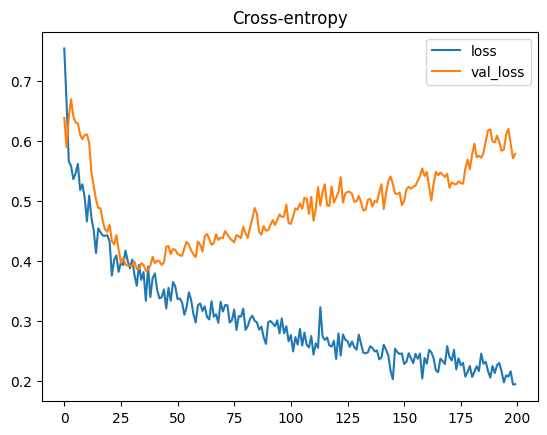

In [7]:
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
print(history_df.shape)

In [8]:
# yhat_test = np.where(model.predict(X_test).squeeze() >= 0.5, 1, 0) 

# output = pd.DataFrame({'PassengerId': X_test.PassengerId.astype('int32'),
#                        'Survived': yhat_test,})

# output.to_csv('submission_nn_val.csv', index=False)